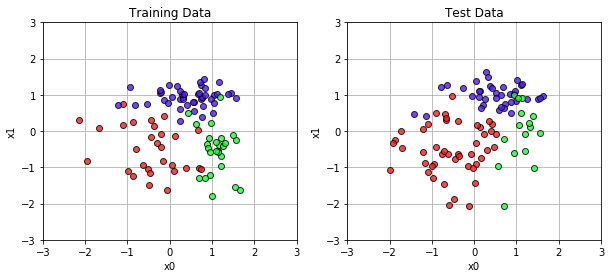

In [2]:
import numpy as np

np.random.seed(seed=1)
N=200  #총 데이터개수
K=3  #클래스의 개수 즉 3분류
T=np.zeros((N,3),dtype=np.uint8)   # [200,3]의 영행렬
X=np.zeros((N,2))    # [200,2]의 영행렬

X_range0=[-3,3]  #X0의 범위
X_range1=[-3,3]
Mu=np.array([[-0.5,-0.5],[0.5,1.0],[1,-0.5]])  #평균
Sig=np.array([[0.7,0.7],[0.8,0.3],[0.3,0.8]])  #표준편차  평균과 표준편차로 정규분포를 따르게하기위함
Pi=np.array([0.4,0.8,1])  #0부터1사이에 간격을 0~0.4 / 0.4~0.8 / 0.8~1의 구간으로 나눠서 각각 클래스1 클래스2 클래스3의 확률 (각 40%,40%,20%)

for n in range(N):   #200번실행
    wk=np.random.rand()  #랜덤넘버생성
    for k in range(K):  #3번 즉 클래스0 클래스1 클래스2
        if wk<Pi[k]:  #생성된 랜덤넘버가 0.4보다 작으면 클래스0 0.4~0.8이면 클래스1 아니면 클래스2
            T[n,k]=1  #1로해줘서 클래스생성
            break
    for k in range(2):  #2번실행
        X[n,k]=np.random.randn()*Sig[T[n,:]==1,k]+Mu[T[n,:]==1,k]  #정규분포를 따르는 랜덤넘버를 생성
        
TestRatio=0.5  #만든 데이터200개를 100개는 훈련, 100개는 테스트 용도로 나눔
X_n_training=int(N*TestRatio)  #훈련데이터를 200*0.5해서 100으로 해줌
X_train=X[:X_n_training,:]  #처음부터 트레이닝까지(100까지) 즉 0,1,2,...99번까지의 행번호를 X_train에 넣음
X_test=X[X_n_training:,:]
T_train=T[:X_n_training,:]
T_test=T[X_n_training:,:]

np.savez('class_data.npz',X_train=X_train, T_train=T_train, X_test=X_test, T_test=T_test, X_range0=X_range0, X_range1=X_range1)

import matplotlib.pyplot as plt
%matplotlib inline

def Show_data(x,t):
    wk,n=t.shape  #.tshape으로 행과 열을 알려줌 그걸 wk,n에 넣음 wk가 행 n이 열
    c=[[1,0.1,0.1],[0.3,0.1,1],[0.1,1,0.2]]
    for i in range(n):
        plt.plot(x[t[:,i]==1,0],x[t[:,i]==1,1],linestyle='none',marker='o',markeredgecolor='black',color=c[i],alpha=0.8)
        plt.grid(True)
        
plt.figure(1,figsize=(10,4))
plt.subplot(1,2,1)
Show_data(X_train,T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Training Data')
plt.subplot(1,2,2)
Show_data(X_test,T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Test Data')
plt.show()

#왼쪽 100개점은 훈련에 쓰일 100개데이터
#오른쪽은 테스트에 사용할 데이터

#가중치(매개변수)를 구할때는 왼쪽100개만 사용
#성능검증할땐 오른쪽 100개만 사용

In [3]:
def Sigmoid(x):   #시그모이드함수
    y=1/(1+np.exp(-x))
    return y;

def FNN(wv,M,K,x):   #뉴런네트워크의 동작을 나타냄  wv는 w벡터랑 v벡터랑 붙여놓은거
                        #M은 중간층 노드수 x는 훈련데이터입력
    N, D=x.shape      #x라는 행렬의 행열의 개수를 N과D에 넣어줌 N이 열의개수 D가 행의개수
    w=wv[:M*(D+1)]   #중간층 매개변수 w의 행렬(노트참고)
    w=w.reshape(M,(D+1))  #리셰입해줘서 수학식과 같게 만들어줌
    v=wv[M*(D+1):]
    v=v.reshape((K,M+1))
    b=np.zeros((N,M+1))
    z=np.zeros((N,M+1))
    a=np.zeros((N,K))
    y=np.zeros((N,K))
    
    for n in range(N):
        for m in range(M):    # np.dot(a,b)는 a와b의 내적  //  np.r_ 이거는 두 벡터를 이어줌
            b[n,m]=np.dot(w[m,:],np.r_[x[n,:],1])  #w[m,:] m이 0이면 [w00,w01,w02..]  여튼이건 [w00,w01,w02..]내적[x0,x1,..xD-1,1] 이 1은 np.r_로 뒤에 이어준거임  
            z[n,m]=Sigmoid(b[n,m])
        z[n,M]=1
        wkz=0
        for k in range(K):
            a[n,k]=np.dot(v[k,:],z[n,:])
            wkz=wkz+np.exp(a[n,k])
        for k in range(K):
            y[n,k]=np.exp(a[n,k])/wkz
    return y,a,z,b
         #array첫번째꺼가 y(출력)
        #두번째꺼가 a(출력층의 입력)
        #세번째거가 z(중간층출력)
        #4번째가 b(중간층입력)
        
        #즉 a를 소프트맥스에 넣어서 y가 나왔고 b를 시그모이드에 넣어서 z가 나왔다

WV=np.ones(15)  # [1,1,1,1,....1,1] 15개의 1, 이중 몇개는 w이고 몇개는 v이다 (노트참고)
M=2  #입력2개
K=3  #출력3개
FNN(WV,M,K,X_train[:2,:])
            

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [4]:
def CE_FNN(wv,M,K,x,t):  #3변수의 CEE
    N,D=x.shape
    y,a,z,b=FNN(wv,M,K,x)
    ce=-np.dot(np.log(y.reshape(-1)),t.reshape(-1))/N
    return ce

WV=np.ones(15)
M=2
K=3
CE_FNN(WV,M,K,X_train[:2,:],T_train[:2,:])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


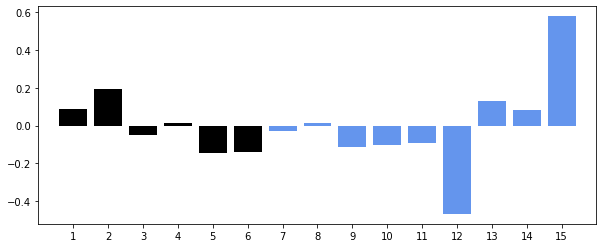

In [5]:
def dCE_FNN_num(wv,M,K,x,t):
    epsilon=0.001
    dwv=np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified=wv.copy()
        wv_modified[iwv]=wv[iwv]-epsilon
        mse1=CE_FNN(wv_modified,M,K,x,t)
        wv_modified[iwv]=wv[iwv]+epsilon
        mse2=CE_FNN(wv_modified,M,K,x,t)
        dwv[iwv]=(mse2-mse1)/(2*epsilon)
    return dwv

def Show_WV(wv,M):
    N=wv.shape[0]
    plt.bar(range(1,M*3+1),wv[:M*3],align="center",color="black")
    plt.bar(range(M*3+1,N+1),wv[M*3:],align="center",color="cornflowerblue")
    plt.xticks(range(1,N+1))
    plt.xlim(0,N+1)
    
M=2
K=3
nWV=M*3+K*(M+1)
np.random.seed(1)
WV=np.random.normal(0,1,nWV)
dWV=dCE_FNN_num(WV,M,K,X_train[:2,:],T_train[:2,:])
print(dWV)
plt.figure(1,figsize=(10,4))
Show_WV(dWV,M)
plt.show()
    

            

In [7]:
import time


def Fit_FNN_num(wv_init,M,K,x_train,t_train,x_test,t_test,n,alpha):  #수치적인방식으로 최적화를시키겟다
    wvt=wv_init  #초기값
    err_train=np.zeros(n)  #에러값정의 0으로
    err_test=np.zeros(n)
    wv_hist=np.zeros((n,len(wv_init)))
    epsilon=0.001  #최소증분
    for i in range(n):
        wvt=wvt- alpha * dCE_FNN_num(wvt,M,K,x_train,t_train) #다음시간의 wvt는 현재순간의 wvt에 기울기의 반대방향으로 알파(학습률)배만큼 이동하라
        err_train[i]=CE_FNN(wvt,M,K,x_train,t_train)
        err_test[i]=CE_FNN(wvt,M,K,x_test,t_test)
        wv_hist[i,:]=wvt #그 결과wvt를 히스토리에 넣어줌
    return wvt,wv_hist,err_train,err_test

startTime=time.time()  #지금시간을 startTime에 넣어줌
M=2  #입력2개
K=3  #출력3개
np.random.seed(1)
WV_init=np.random.normal(0,0.01,M*3+K*(M+1))
N_step=1000  #1000번의 스텝만큼 실행하겠다
alpha=0.5  #학습률(이게 크면 빨리수렴할수있지만 정확히 수렴이 안되는경우 무한루프에 빠진다 작게잡으면 좀 오래걸리지만(한걸음이 작으니까)하지만 정확하고 안정적)
WV,WV_hist,Err_train,Err_test=Fit_FNN_num(WV_init,M,K,X_train,T_train,X_test,T_test,N_step,alpha)
calculation_time=time.time()-startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:572.100 sec


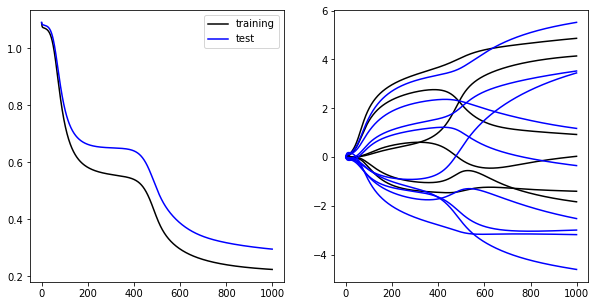

In [13]:
plt.figure(1,figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(Err_train,'-k',label='training')
plt.plot(Err_test,'-b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(WV_hist[:,:M*3],'-k')
plt.plot(WV_hist[:,M*3:],'-b')
plt.show()

#1,2,1그래프에서 오차가 쭉 떨어지다가 평평한부분 두군대 나타암
#이거를 고원효과라고함
#1,2,2그래프에서 0~400구간(고원지역)이후 급격한 변화의 부분이있음
#그 이후 수렴하기시작함


ValueError: cannot reshape array of size 6 into shape (3,3)

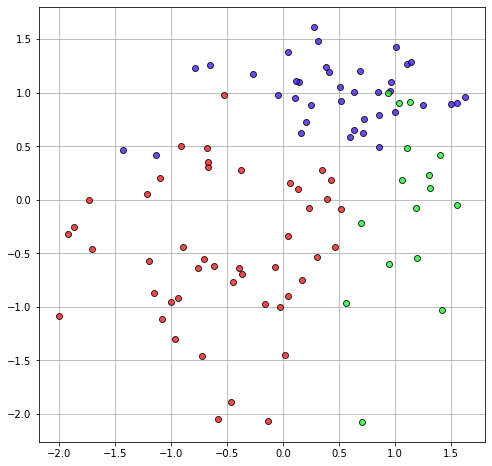

In [14]:
def show_FNN(wv,M,K):
    xn=60
    x0=np.linspace(X_range0[0],X_range0[1],xn)
    x1=np.linspace(X_range1[0],X_range1[1],xn)
    xx0,xx1=np.meshgrid(x0,x1)
    x=np.meshgrid(x0,x1)
    x = np.c_[np.reshape(xx0, (xn * xn, 1), 'F'), np.reshape(xx1, (xn * xn, 1), 'F')]
    y,a,z,b=FNN(wv,M,K,x)
    plt.figure(1,figsize=(4,4))
    for ic in range(K):
        f=y[:,ic]
        f=f.reshape(xn,xn)
        f=f.T
        cont=plt.contour(xx0,xx1,f,levels=[0.5,0.9],colors=['blue','black'])
        cont.clabel(fmt='%1.1f',fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
        
plt.figure(1,figsize=(8,8))
Show_data(X_test,T_test)
show_FNN(WV,M,K)
plt.show()
    

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


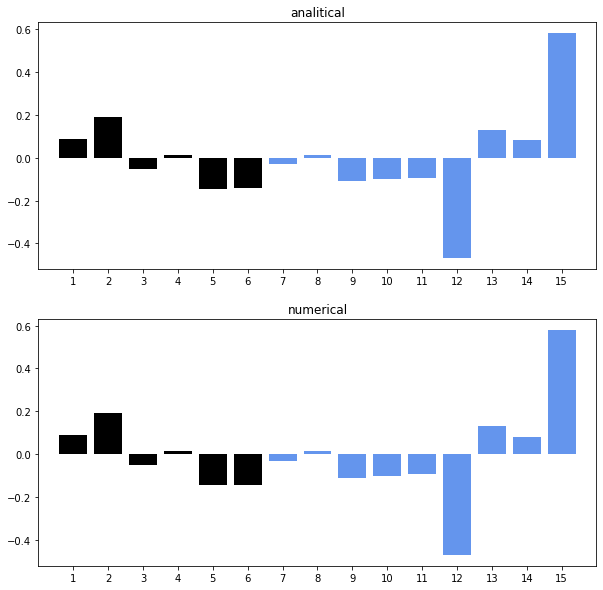

In [21]:
def dCE_FNN(wv, M, K, x ,t):
    
    N, D=x.shape
    w=wv[:M * (D + 1)]
    w=w.reshape(M, (D + 1))
    v=wv[M * (D + 1):]
    v=v.reshape((K, M+1))
    
    y,a,z,b=FNN(wv,M,K,x)
    
    dwv=np.zeros_like(wv)
    dw=np.zeros((M , D + 1))
    dv=np.zeros((K , M + 1))
    delta1=np.zeros(M)
    delta2=np.zeros(K)
    for n in range(N):
        for k in range(K):
            delta2[k]=(y[n,k]-t[n,k])
            
        for j in range(M):
            delta1[j]=z[n,j]*(1-z[n,j])*np.dot(v[:,j],delta2)
        
        for k in range(K):
            dv[k,:]=dv[k,:]+delta2[k]*z[n,:]/N
            
        for j in range(M):
            dw[j,:]=dw[j,:]+delta1[j]*np.r_[x[n,:],1]/N
            
    dwv=np.c_[dw.reshape((1,M*(D+1))),dv.reshape((1,K*(M+1)))]
    dwv=dwv.reshape(-1)
    return dwv

def Show_dWV(wv,M):
    N=wv.shape[0]
    plt.bar(range(1,M*3+1),wv[:M*3],align="center",color='black')
    plt.bar(range(M*3+1,N+1),wv[M*3:],align="center",color='cornflowerblue')
    plt.xticks(range(1,N+1))
    plt.xlim(0,N+1)
    
M=2
K=3
N=2
nWV=M*3+K*(M+1)
np.random.seed(1)
WV=np.random.normal(0,1,nWV)
    
dWV_ana=dCE_FNN(WV,M,K,X_train[:N,:],T_train[:N,:])
print("analytical dWV")
print(dWV_ana)
    
dWV_num=dCE_FNN_num(WV,M,K,X_train[:N,:],T_train[:N,:])
print("numerical dWV")
print(dWV_num)
    
plt.figure(1,figsize=(10,10))
plt.subplots_adjust(wspace=0.5)
plt.subplot(2,1,1)
Show_dWV(dWV_ana,M)
plt.title('analitical')
plt.subplot(2,1,2)
Show_dWV(dWV_num,M)
plt.title('numerical')
plt.show()
    

In [16]:
import time

def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wv=wv_init.copy()
    err_train=np.zeros(n)
    err_test=np.zeros(n)
    wv_hist=np.zeros((n,len(wv_init)))
    epsilon=0.001
    for i in range(n):
        wv=wv-alpha*dCE_FNN(wv,M,K,x_train,t_train)
        err_train[i]=CE_FNN(wv,M,K,x_train,t_train)
        err_test[i]=CE_FNN(wv,M,K,x_test,t_test)
        wv_hist[i,:]=wv
    return wv,wv_hist,err_train,err_test

startTime=time.time()
M=2
K=3
np.random.seed(1)
WV_init=np.random.normal(0,0.01,M*3+K*(M+1))
N_step=1000
alpha=1
WV,WV_hist,Wrr_train,Err_test=Fit_FNN(WV_init,M,K,X_train,T_train,X_test,T_test,N_step,alpha)
calculation_time=time.time()-startTime
print("Calculation time:{0:.3f}sec".format(calculation_time))

#오차역전알고리즘을 사용하니 앞에서 무식하게 경사하강법만 쓰는거보다 시간이 많이 단축됐다

Calculation time:60.753sec


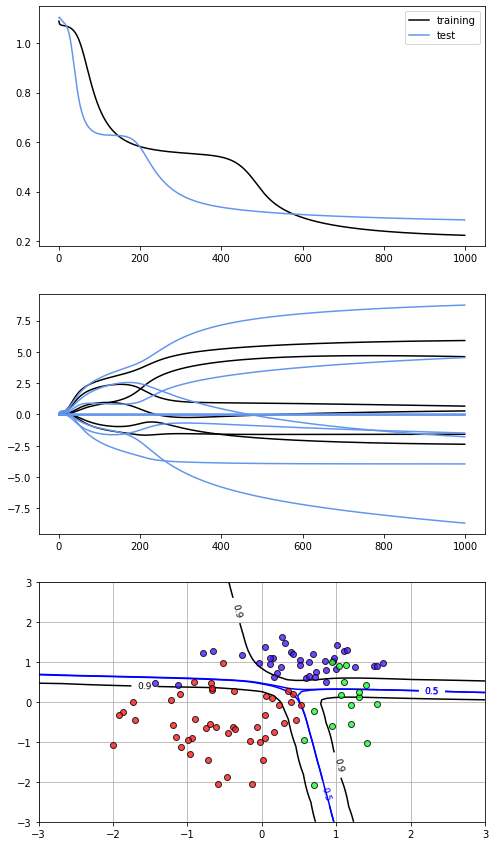

In [19]:
plt.figure(1,figsize=(8,15))
plt.subplots_adjust(wspace=0.5)

plt.subplot(3,1,1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()

plt.subplot(3,1,2)
plt.plot(WV_hist[:,:M*3], 'black')
plt.plot(WV_hist[:,M*3:], 'cornflowerblue')

plt.subplot(3,1,3)
Show_data(X_test, T_test)
M=2
K=3
show_FNN(WV,M,K)
plt.show()